<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/CA_FeatureRanking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal:
Using Random Forest to estimate the gini index and feature importance for all features from CA dataset

Using Scikit-learn to compute PCA

## Mount Google drive

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler as ss
import itertools
from scipy import linalg
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import numpy as np
import matplotlib.pyplot as plt

# 1.Load data - Combined CA Data

In [76]:
CA_labeled_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA/CA_labeledData_LosAngeles_Oct11.csv',low_memory=False)
print(CA_labeled_data.shape)

(172, 19)


In [77]:
CA_labeled_data.dtypes

Date                        object
fips_x                       int64
County Name                 object
population                   int64
retail and recreation      float64
grocery and pharmacy       float64
parks                      float64
transit stations           float64
workplaces                 float64
residential                float64
driving                    float64
m50                        float64
m50_index                    int64
population_density         float64
mask_rule_active             int64
mask_wearing_percent       float64
New cases                    int64
New Cases/1k population    float64
growth_label                object
dtype: object

## Preprocessing data 

* drop na
* convert categorical code

In [78]:
CA_labeled_data['growth_code'] = CA_labeled_data['growth_label'].astype('category').cat.codes

CA_labeled_data.head(2)

,Date,fips_x,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,New Cases/1k population,growth_label,growth_code
0,2020-03-01,6037,Los Angeles County,10039107,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.0,0,0.0,drastic_decrement,0
1,2020-03-02,6037,Los Angeles County,10039107,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.0,0,0.0,drastic_decrement,0


In [79]:
CA_labeled_data = CA_labeled_data.dropna()

In [80]:
#CA_labeled_data[pd.isna(CA_labeled_data['growth_label'])]

In [81]:
#CA_labeled_data['label_code'].unique()

In [82]:
CA_labeled_data['growth_code'] = CA_labeled_data['growth_label'].astype('category').cat.codes
CA_labeled_data.head()

,Date,fips_x,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,New Cases/1k population,growth_label,growth_code
0,2020-03-01,6037,Los Angeles County,10039107,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.0,0,0.000000,drastic_decrement,0
1,2020-03-02,6037,Los Angeles County,10039107,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.0,0,0.000000,drastic_decrement,0
2,2020-03-03,6037,Los Angeles County,10039107,8.0,7.0,32.0,2.0,3.0,-1.0,17.24,6.591,99,2473.978284,0,0.0,0,0.000000,drastic_decrement,0
3,2020-03-04,6037,Los Angeles County,10039107,4.0,6.0,9.0,-1.0,2.0,0.0,13.82,6.595,100,2473.978284,0,0.0,6,0.000598,drastic_decrement,0
4,2020-03-05,6037,Los Angeles County,10039107,4.0,7.0,9.0,0.0,2.0,0.0,22.17,7.008,106,2473.978284,0,0.0,4,0.000398,drastic_decrement,0


Get unique values of two columns

In [83]:
pd.unique(CA_labeled_data[['growth_label', 'growth_code']].values.ravel())

array(['drastic_decrement', 0, 'mild_decrement', 3, 'mild_growth', 4,
       'flat_growth', 2, 'drastic_growth', 1], dtype=object)

In [84]:
CA_labeled_data['growth_code'].unique()

array([0, 3, 4, 2, 1], dtype=int8)

In [85]:
CA_labeled_data.dtypes

Date                        object
fips_x                       int64
County Name                 object
population                   int64
retail and recreation      float64
grocery and pharmacy       float64
parks                      float64
transit stations           float64
workplaces                 float64
residential                float64
driving                    float64
m50                        float64
m50_index                    int64
population_density         float64
mask_rule_active             int64
mask_wearing_percent       float64
New cases                    int64
New Cases/1k population    float64
growth_label                object
growth_code                   int8
dtype: object

In [86]:
feature_labels = ['retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index',
               'population_density','mask_rule_active']

target_column = ['growth_code']

X = CA_labeled_data[feature_labels]
y = CA_labeled_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


## Train Random Forest classifier

In [87]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


('retail and recreation', 0.11702171770769759)
('grocery and pharmacy', 0.1245669258307571)
('parks', 0.09253988610269637)
('transit stations', 0.08270382295645459)
('workplaces', 0.08457439300703676)
('residential', 0.07157277412555042)
('driving', 0.1583529196139357)
('m50', 0.10367041250269068)
('m50_index', 0.08769511517757116)
('population_density', 0.0)
('mask_rule_active', 0.07730203297560982)


In [88]:

#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.12563080163711668)
('grocery and pharmacy', 0.12922781803420366)
('parks', 0.09531517154320582)
('transit stations', 0.08592440076185373)
('workplaces', 0.07971257117353531)
('residential', 0.06511970471752503)
('driving', 0.15969964432159825)
('m50', 0.10201440456228587)
('m50_index', 0.08512559362001011)
('population_density', 0.0)
('mask_rule_active', 0.07222988962866539)


## PCA Computation

In [89]:
print(len(feature_labels))

11


In [90]:
# split into training and testing datasets


X = CA_labeled_data[feature_labels].values
y = CA_labeled_data[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=0)
print(X_train.shape)
print(y_train.shape)

(120, 11)
(120, 1)


In [91]:
# standardize the features
sc = ss()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [92]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [93]:
principalDf

,principal component 1,principal component 2
0,67.762555,32.339484
1,101.698837,38.260046
2,117.341807,21.843220
3,105.170413,33.882759
4,113.326609,32.205038
...,...,...
167,39.226197,-7.910583
168,45.592815,-5.022222
169,43.416918,-9.699809
170,48.605367,-7.162312


In [94]:
finalDf = pd.concat([principalDf, CA_labeled_data[target_column]],axis=1 )
finalDf

,principal component 1,principal component 2,growth_code
0,67.762555,32.339484,0
1,101.698837,38.260046,0
2,117.341807,21.843220,0
3,105.170413,33.882759,0
4,113.326609,32.205038,0
...,...,...,...
167,39.226197,-7.910583,4
168,45.592815,-5.022222,2
169,43.416918,-9.699809,1
170,48.605367,-7.162312,1


0
1
2


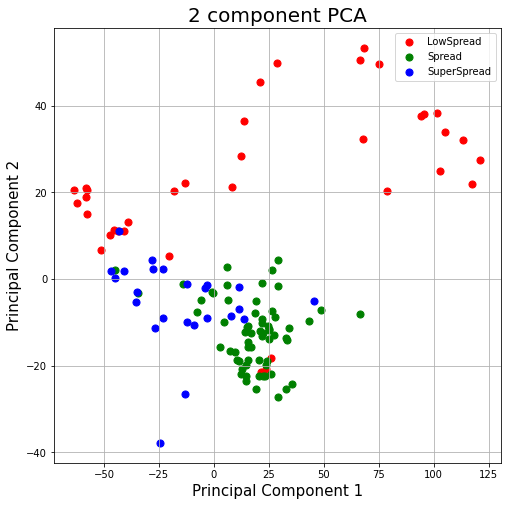

In [95]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['LowSpread', 'Spread', 'SuperSpread']
targets2 = np.unique(y_train)
colors = ['r', 'g', 'b']
for target, color in zip(targets2,colors):
    print(target)
    indicesToKeep = finalDf['growth_code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [96]:
#obtain the eigenpairs of the Wine covariance matrix:
#data_cov = np.dot(np.transpose(data.values),data.values)
#data_cov
X_train_cov = np.cov(X_train_std.T)
w, v = np.linalg.eig(X_train_cov)

In [97]:
#The percent of variability contained within each component
w_percent = (w/np.sum(w))*100                 
print(w, '-> eigenvalues')
print(w_percent, ' -> percent of variability explained')

[6.70120608e+00 1.53866145e+00 6.63256008e-01 4.08857916e-01
 3.51333253e-01 2.63358058e-01 9.53569345e-02 3.30828544e-02
 2.88524416e-02 6.86151652e-05 0.00000000e+00] -> eigenvalues
[6.64536270e+01 1.52583927e+01 6.57728874e+00 4.05450767e+00
 3.48405476e+00 2.61163407e+00 9.45622934e-01 3.28071639e-01
 2.86120046e-01 6.80433722e-04 0.00000000e+00]  -> percent of variability explained


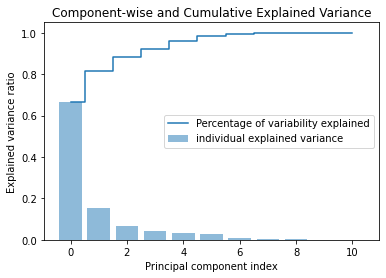

In [98]:
# calculate cumulative sum of explained variances
tot = sum(w)
var_exp = [(i / tot) for i in sorted(w, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.title("Component-wise and Cumulative Explained Variance")
plt.bar(range(0,11), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(0,11), cum_var_exp, where='mid',
         label='Percentage of variability explained')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [99]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(w[i]), v[:, i]) for i in range(len(w))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
w2 = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W2:\n', w2)

Matrix W2:
 [[-0.35802649  0.01378385]
 [-0.32007107 -0.21248524]
 [-0.29419875  0.36768185]
 [-0.34904633 -0.07643371]
 [-0.29164099 -0.37993596]
 [ 0.32999972  0.13847629]
 [-0.31912309  0.38546721]
 [-0.35166774 -0.10997002]
 [-0.35163566 -0.10983886]
 [ 0.          0.        ]
 [-0.13369229  0.690911  ]]


In [100]:
X_train_pca = X_train_std.dot(w2)
print(X_train_pca)

[[ 2.68080727 -0.52094351]
 [-1.11113478  1.73401545]
 [ 0.72314511  0.43271011]
 [-6.47531172 -2.30163444]
 [ 4.62925813 -1.11128284]
 [-1.41242609  1.43912263]
 [-1.1020069   1.39452502]
 [ 0.3943444  -0.43160316]
 [-0.66611447  1.42702529]
 [ 0.43225999  0.64038693]
 [-1.02485544  1.380217  ]
 [-6.42065216 -2.3002783 ]
 [-2.69853621  1.34843236]
 [ 4.19143913 -0.59922438]
 [-6.83649194 -2.29203158]
 [-2.65309789  1.24976668]
 [-1.42034326  1.29459733]
 [-2.30106316 -2.4396522 ]
 [ 1.28604354 -0.08277167]
 [ 4.09259341 -0.41270851]
 [-0.42054506 -0.05244559]
 [ 2.55625611 -0.56336524]
 [-1.5564172   0.89090666]
 [ 3.02520414 -0.380511  ]
 [-1.02512755  1.78420234]
 [ 0.69233357 -0.77570733]
 [-7.37016229 -1.93640161]
 [ 3.67627956 -1.2087344 ]
 [-4.78593775 -2.83115064]
 [-1.99788778  1.27723188]
 [-2.96747933  1.29721064]
 [-0.67310748  1.36619584]
 [-0.87741389  1.64087455]
 [ 2.25446484 -0.23831361]
 [ 3.30451417 -1.11863596]
 [-2.20566503 -2.39326139]
 [ 3.6211448  -0.4881247 ]
 

In [101]:
np.unique(y_train)
X_train_pca

array([[ 2.68080727, -0.52094351],
       [-1.11113478,  1.73401545],
       [ 0.72314511,  0.43271011],
       [-6.47531172, -2.30163444],
       [ 4.62925813, -1.11128284],
       [-1.41242609,  1.43912263],
       [-1.1020069 ,  1.39452502],
       [ 0.3943444 , -0.43160316],
       [-0.66611447,  1.42702529],
       [ 0.43225999,  0.64038693],
       [-1.02485544,  1.380217  ],
       [-6.42065216, -2.3002783 ],
       [-2.69853621,  1.34843236],
       [ 4.19143913, -0.59922438],
       [-6.83649194, -2.29203158],
       [-2.65309789,  1.24976668],
       [-1.42034326,  1.29459733],
       [-2.30106316, -2.4396522 ],
       [ 1.28604354, -0.08277167],
       [ 4.09259341, -0.41270851],
       [-0.42054506, -0.05244559],
       [ 2.55625611, -0.56336524],
       [-1.5564172 ,  0.89090666],
       [ 3.02520414, -0.380511  ],
       [-1.02512755,  1.78420234],
       [ 0.69233357, -0.77570733],
       [-7.37016229, -1.93640161],
       [ 3.67627956, -1.2087344 ],
       [-4.78593775,

# 2.Load data - Maryland Inertia Data

In [114]:
CA_inertia_labeled_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/CA/CA_sd_inertia_labeledData_LosAngeles_Oct11.csv',low_memory=False)
print(CA_inertia_labeled_data.shape)

(212, 54)


In [115]:
CA_inertia_labeled_data.describe()

,FIPS,Confirmed,Deaths,New cases,New deaths,mask_rule_active,CTFIPS,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases
count,212.0,212.000000,212.000000,212.000000,212.000000,212.000000,212.0,212.0,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.0,212.000000,2.120000e+02,212.0,212.0,2.120000e+02,212.0,2.120000e+02,212.0,212.0,212.0,2.120000e+02,2.120000e+02,0.0,0.0,212.0,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,6037.0,59344.740566,1801.297170,1072.386792,25.688679,0.301887,6037.0,6.0,40.367925,29.377358,2.871321,10.433962,0.339151,29.970755,0.406368,2.464717,1072.386792,10105518.0,-10.880660,6.040000e+00,18.0,64251.0,7.900000e+00,48.5,4.928000e+01,2125.0,972.0,140.0,2.050000e+00,2.200000e-01,NaN,NaN,9.0,8.829906,52.830189,6.745283,18.265566,22.638208,0.397594,0.890708,0.105379,1.895142,3.216981,56.306571,6.795755,59.918019,12.413632,488.528302,3510.033019
std,0.0,70740.002317,1803.921353,1160.354739,24.433239,0.460163,0.0,0.0,15.190310,6.936343,0.370029,0.809059,0.197437,6.652697,0.150360,0.301543,1160.354739,0.0,10.899835,1.780561e-14,0.0,0.0,2.492786e-14,0.0,7.834469e-14,0.0,0.0,0.0,7.567385e-15,6.398892e-16,NaN,NaN,0.0,12.207460,43.006772,5.522846,9.513517,9.907716,0.491413,0.656312,0.101539,2.231713,6.574408,1.857983,5.493782,76.609141,9.075501,374.901256,4441.806274
min,6037.0,0.000000,0.000000,0.000000,0.000000,0.000000,6037.0,6.0,13.000000,17.000000,1.790000,7.100000,0.100000,13.800000,0.180000,1.610000,0.000000,10105518.0,-41.800000,6.040000e+00,18.0,64251.0,7.900000e+00,48.5,4.928000e+01,2125.0,972.0,140.0,2.050000e+00,2.200000e-01,NaN,NaN,9.0,0.000000,0.000000,0.900000,3.900000,5.700000,-0.600000,0.000000,0.000000,0.000000,0.000000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6037.0,53.000000,1.000000,6.750000,0.000000,0.000000,6037.0,6.0,34.000000,26.750000,2.627500,10.100000,0.200000,25.075000,0.250000,2.260000,6.750000,10105518.0,-18.300000,6.040000e+00,18.0,64251.0,7.900000e+00,48.5,4.928000e+01,2125.0,972.0,140.0,2.050000e+00,2.200000e-01,NaN,NaN,9.0,0.187500,14.000000,3.900000,5.675000,19.525000,0.200000,0.077500,0.000850,0.010000,0.000000,54.092556,5.300000,0.030000,0.207500,17.250000,13.750000
50%,6037.0,29088.000000,1393.500000,837.500000,21.000000,0.000000,6037.0,6.0,40.000000,29.000000,2.870000,10.600000,0.300000,30.900000,0.420000,2.495000,837.500000,10105518.0,-9.800000,6.040000e+00,18.0,64251.0,7.900000e+00,48.5,4.928000e+01,2125.0,972.0,140.0,2.050000e+00,2.200000e-01,NaN,NaN,9.0,3.440000,42.000000,6.200000,23.400000,26.700000,0.300000,0.870000,0.090450,1.080000,0.000000,56.782021,6.100000,20.880000,15.155000,629.500000,1577.000000
75%,6037.0,98678.000000,3311.500000,1709.250000,46.000000,1.000000,6037.0,6.0,50.250000,33.250000,3.070000,10.900000,0.400000,34.500000,0.440000,2.692500,1709.250000,10105518.0,-2.625000,6.040000e+00,18.0,64251.0,7.900000e+00,48.5,4.928000e+01,2125.0,972.0,140.0,2.050000e+00,2.200000e-01,NaN,NaN,9.0,11.880000,84.000000,7.300000,26.200000,29.1

## Preprocessing data 

* drop na
* convert categorical code

In [104]:
# CA_inertia_labeled_data['label_code'] = CA_inertia_labeled_data['label'].astype('category').cat.codes

# CA_inertia_labeled_data.head(2)

In [116]:
CA_inertia_labeled_data = CA_inertia_labeled_data.fillna(0)

In [106]:
# CA_inertia_labeled_data[pd.isna(CA_inertia_labeled_data['label'])]

In [107]:
# CA_inertia_labeled_data['label_code'].unique()

In [117]:
CA_inertia_labeled_data['growth_code'] = CA_inertia_labeled_data['growth_label'].astype('category').cat.codes
CA_inertia_labeled_data.head()

,Date,Province_State,FIPS,Confirmed,Deaths,New cases,New deaths,mask_rule_active,CTFIPS,CTNAME,STFIPS,Social distancing index,% staying home,Trips/person,% out-of-county trips,% out-of-state trips,Miles/person,Work trips/person,Non-work trips/person,New COVID cases,Population,% change in consumption,date,Transit mode share,% people older than 60,Median income,% African Americans,% Hispanic Americans,% Male,Population density,Employment density,# hot spots/1000 people,Hospital beds/1000 people,ICUs/1000 people,# contact tracing workers/1000 people,# contact tracing workers/1000 people rank,% people older than 60 rank,COVID exposure/1000 people,#days: decreasing ILI cases,Unemployment claims/1000 people,Unemployment rate,% working from home,Cumulative inflation rate,COVID death rate,New cases/1000 people,Active cases/1000 people,#days: decreasing COVID cases,% hospital bed utilization,Testing capacity,Tests done/1000 people,% ICU utilization,Ventilator shortage,Imported COVID cases,growth_label,growth_code
0,2020-01-22,California,6037,0,0,0,0,0,6037,Los Angeles County,6,18,19,3.34,10.9,0.3,32.5,0.62,2.72,0,10105518,-1.7,2020-01-22,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,0,1.2,3.9,5.7,0.3,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,drastic_decrement,0
1,2020-01-23,California,6037,0,0,0,0,0,6037,Los Angeles County,6,15,19,3.43,10.9,0.4,34.7,0.63,2.80,0,10105518,1.2,2020-01-23,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,0,1.2,3.9,5.7,0.3,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,drastic_decrement,0
2,2020-01-24,California,6037,0,0,0,0,0,6037,Los Angeles County,6,14,18,3.53,11.1,0.4,37.4,0.60,2.93,0,10105518,5.9,2020-01-24,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,0,1.2,3.9,5.7,0.3,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,drastic_decrement,0
3,2020-01-25,California,6037,0,0,0,0,0,6037,Los Angeles County,6,25,22,3.24,11.8,0.4,34.6,0.31,2.93,0,10105518,5.9,2020-01-25,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,0,1.2,3.9,5.7,0.3,0.0,0.0,0.0,1,54.0,0.0,0.0,0.0,0,0,drastic_decrement,0
4,2020-01-26,California,6037,1,0,1,0,0,6037,Los Angeles County,6,37,27,2.83,11.5,0.5,33.5,0.26,2.57,1,10105518,-7.1,2020-01-26,6.04,18,64251,7.9,48.5,49.28,2125,972,140,2.05,0.22,0.0,0.0,9,0.0,0,1.1,3.9,5.7,0.3,0.0,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,drastic_decrement,0


In [118]:
CA_inertia_labeled_data['growth_code'].unique()

array([0, 3, 2, 4, 1], dtype=int8)

In [119]:
CA_inertia_labeled_data.dtypes

Date                                           object
Province_State                                 object
FIPS                                            int64
Confirmed                                       int64
Deaths                                          int64
New cases                                       int64
New deaths                                      int64
mask_rule_active                                int64
CTFIPS                                          int64
CTNAME                                         object
STFIPS                                          int64
Social distancing index                         int64
% staying home                                  int64
Trips/person                                  float64
% out-of-county trips                         float64
% out-of-state trips                          float64
Miles/person                                  float64
Work trips/person                             float64
Non-work trips/person       

In [111]:
CA_inertia_labeled_data.columns

Index(['Date', 'Province_State', 'FIPS', 'Confirmed', 'Deaths', 'New cases',
       'New deaths', 'mask_rule_active', 'CTFIPS', 'CTNAME', 'STFIPS',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
       '#days: decreasing ILI cases', 'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation

In [113]:
X.shape

(0, 33)

In [120]:
feature_labels = ['mask_rule_active','Social distancing index','% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person','Non-work trips/person','% change in consumption',
       'Transit mode share','% people older than 60', 'Median income', '% African Americans', '% Hispanic Americans',
       '% Male', 'Population density','Employment density', '# hot spots/1000 people','Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people rank','% people older than 60 rank', 'COVID exposure/1000 people',
       'Unemployment claims/1000 people', 'Unemployment rate','% working from home', 'Cumulative inflation rate',
       '% hospital bed utilization', 'Testing capacity','Tests done/1000 people', '% ICU utilization', 'Ventilator shortage'
       ]

target_column = ['growth_code']

X = CA_inertia_labeled_data[feature_labels]
y = CA_inertia_labeled_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


## Train Random Forest classifier

In [121]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


('mask_rule_active', 0.03549580541025612)
('Social distancing index', 0.03625451218986089)
('% staying home', 0.029447997387091595)
('Trips/person', 0.029118059181699043)
('% out-of-county trips', 0.03209255468267571)
('% out-of-state trips', 0.028717288822265513)
('Miles/person', 0.05712371185649717)
('Work trips/person', 0.026710254344338658)
('Non-work trips/person', 0.029316857311423326)
('% change in consumption', 0.02952926193855651)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.11484128861635708)
('Unemployment claims/1000 people', 0.0405458256927298)
('Unemployment rate', 0.05570341307058552)
('% work

In [122]:

#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)
print(X_train.shape)
# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


(127, 33)
('mask_rule_active', 0.03375480682394056)
('Social distancing index', 0.03343693165017526)
('% staying home', 0.024522430751290465)
('Trips/person', 0.025882833717974355)
('% out-of-county trips', 0.0285375299758826)
('% out-of-state trips', 0.026778663306476963)
('Miles/person', 0.06381335182851713)
('Work trips/person', 0.022417721584045612)
('Non-work trips/person', 0.025798610922985285)
('% change in consumption', 0.025621931592395324)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.12504774036311783)
('Unemployment claims/1000 people', 0.039366026751324404)
('Unemployment rate', 0.076083501491579

In [ ]:
X_train.shape

## PCA Computation

In [123]:
print(len(feature_labels))

33


In [125]:
# split into training and testing datasets


X = CA_inertia_labeled_data[feature_labels].values
y = CA_inertia_labeled_data[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y, random_state=0)
print(X_train.shape)
print(y_train.shape)

(148, 33)
(148, 1)


In [126]:
# standardize the features
sc = ss()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [127]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [128]:
principalDf

,principal component 1,principal component 2
0,-492.826340,24.252769
1,-492.877909,25.313838
2,-492.913980,26.379720
3,-492.734881,24.009998
4,-492.477964,19.988455
...,...,...
207,825.813090,60.937451
208,830.255587,63.608635
209,833.634258,66.423031
210,866.536933,63.788564


In [129]:
finalDf = pd.concat([principalDf, CA_inertia_labeled_data[target_column]],axis=1 )
finalDf

,principal component 1,principal component 2,growth_code
0,-492.826340,24.252769,0
1,-492.877909,25.313838,0
2,-492.913980,26.379720,0
3,-492.734881,24.009998,0
4,-492.477964,19.988455,0
...,...,...,...
207,825.813090,60.937451,1
208,830.255587,63.608635,1
209,833.634258,66.423031,4
210,866.536933,63.788564,4


0
1
2


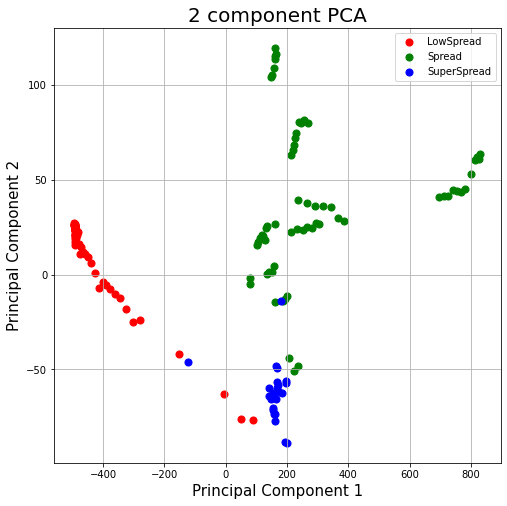

In [131]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['LowSpread', 'Spread', 'SuperSpread']
targets2 = np.unique(y_train)
colors = ['r', 'g', 'b']
for target, color in zip(targets2,colors):
    print(target)
    indicesToKeep = finalDf['growth_code'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [132]:
#obtain the eigenpairs of the Wine covariance matrix:
#data_cov = np.dot(np.transpose(data.values),data.values)
#data_cov
X_train_cov = np.cov(X_train_std.T)
w, v = np.linalg.eig(X_train_cov)

In [133]:
#The percent of variability contained within each component
w_percent = (w/np.sum(w))*100                 
print(w, '-> eigenvalues')
print(w_percent, ' -> percent of variability explained')

[8.56391901e+00 6.33900956e+00 1.75462854e+00 1.00114158e+00
 7.50104245e-01 4.93667825e-01 4.48907556e-01 2.61700090e-01
 2.11066595e-01 1.11114135e-01 6.26548978e-02 5.03292496e-02
 3.73177472e-02 1.93809902e-02 1.57774346e-02 7.93026731e-03
 4.08171223e-03 3.21006544e-03 2.97429715e-06 1.09943689e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00] -> eigenvalues
[4.25302735e+01 3.14808921e+01 8.71386471e+00 4.97188557e+00
 3.72517986e+00 2.45166116e+00 2.22937199e+00 1.29965923e+00
 1.04820235e+00 5.51816820e-01 3.11157770e-01 2.49945936e-01
 1.85328002e-01 9.62501877e-02 7.83541515e-02 3.93834221e-02
 2.02706655e-02 1.59418790e-02 1.47710028e-05 5.46004134e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000

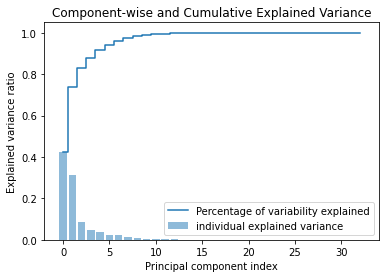

In [134]:
# calculate cumulative sum of explained variances
tot = sum(w)
var_exp = [(i / tot) for i in sorted(w, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

# plot explained variances
plt.title("Component-wise and Cumulative Explained Variance")
plt.bar(range(0,33), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(0,33), cum_var_exp, where='mid',
         label='Percentage of variability explained')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [135]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(w[i]), v[:, i]) for i in range(len(w))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
w2 = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W2:\n', w2)

Matrix W2:
 [[-0.04269282  0.34388811]
 [-0.32877961 -0.0664776 ]
 [-0.32761779 -0.06328518]
 [ 0.31325494  0.07137371]
 [ 0.21068431  0.17234579]
 [ 0.12155542  0.26871305]
 [ 0.23756253  0.25101735]
 [ 0.20325939 -0.1268208 ]
 [ 0.27546444  0.15292671]
 [ 0.27550704  0.15279319]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [-0.05618409  0.37083395]
 [-0.26645945 -0.08805732]
 [-0.20773292  0.24645554]
 [-0.30638492  0.11729539]
 [ 0.11670614  0.13695227]
 [-0.18527409  0.27469997]
 [-0.18705458 -0.10934556]
 [-0.05974344  0.37765971]
 [-0.20375563  0.28565921]
 [-0.19161591  0.30052653]]


In [136]:
X_train_pca = X_train_std.dot(w2)
print(X_train_pca)

[[-4.34461117e-01 -4.66616325e-02]
 [-4.83395032e+00 -2.72013259e+00]
 [-6.31025258e-01  2.79541271e+00]
 [-3.28250004e+00 -1.84029714e+00]
 [-6.35822307e-01  3.71481876e+00]
 [-4.51119601e+00 -3.13148549e+00]
 [-1.51194362e+00 -6.60251765e-01]
 [ 3.45938042e+00 -1.02265498e+00]
 [-2.54750473e+00 -1.36695235e+00]
 [-3.08370198e+00 -1.04994652e+00]
 [-4.11208004e+00 -1.65519551e+00]
 [-4.47940865e+00 -3.04797260e+00]
 [ 3.11865427e-01  6.46067662e-01]
 [-2.22536039e+00 -1.19418949e+00]
 [-1.48664412e+00 -7.57853724e-02]
 [-2.73138519e+00 -3.58074283e+00]
 [-2.99154764e+00 -2.86357338e-01]
 [-3.20730801e+00 -1.73439081e+00]
 [-3.67176611e-01  3.62049388e+00]
 [-2.83727606e+00 -3.62561640e+00]
 [-3.91039368e-01  4.90463469e+00]
 [-1.39481081e+00  2.63229412e+00]
 [-4.12281956e+00 -3.56646718e+00]
 [-1.88084733e-02  2.13202970e-01]
 [ 4.92778122e+00 -1.48607536e+00]
 [-4.72974189e+00 -2.04713679e+00]
 [ 5.30631362e+00 -1.24673893e+00]
 [ 5.65355394e+00 -1.04953004e+00]
 [-8.52449101e-01  1

In [137]:
np.unique(y_train)
X_train_pca

array([[-4.34461117e-01, -4.66616325e-02],
       [-4.83395032e+00, -2.72013259e+00],
       [-6.31025258e-01,  2.79541271e+00],
       [-3.28250004e+00, -1.84029714e+00],
       [-6.35822307e-01,  3.71481876e+00],
       [-4.51119601e+00, -3.13148549e+00],
       [-1.51194362e+00, -6.60251765e-01],
       [ 3.45938042e+00, -1.02265498e+00],
       [-2.54750473e+00, -1.36695235e+00],
       [-3.08370198e+00, -1.04994652e+00],
       [-4.11208004e+00, -1.65519551e+00],
       [-4.47940865e+00, -3.04797260e+00],
       [ 3.11865427e-01,  6.46067662e-01],
       [-2.22536039e+00, -1.19418949e+00],
       [-1.48664412e+00, -7.57853724e-02],
       [-2.73138519e+00, -3.58074283e+00],
       [-2.99154764e+00, -2.86357338e-01],
       [-3.20730801e+00, -1.73439081e+00],
       [-3.67176611e-01,  3.62049388e+00],
       [-2.83727606e+00, -3.62561640e+00],
       [-3.91039368e-01,  4.90463469e+00],
       [-1.39481081e+00,  2.63229412e+00],
       [-4.12281956e+00, -3.56646718e+00],
       [-1.

# Selecting three counties in CA
* Los Angeles
* Riverside
* San Bernardino

### Filtered data for county - From Combined Dataset

In [138]:
la_county_data = CA_labeled_data[CA_labeled_data['County Name'] == 'Los Angeles County']
Westchester_county_data = CA_labeled_data[CA_labeled_data['County Name'] == 'Riverside County']
Suffolk_county_data = CA_labeled_data[CA_labeled_data['County Name'] == 'San Bernardino County']

print(' Nassau county data ',la_county_data.shape)
print(' Westchester county data ',Westchester_county_data.shape)
print(' Suffolk county data ',Suffolk_county_data.shape)

 Nassau county data  (172, 20)
 Westchester county data  (0, 20)
 Suffolk county data  (0, 20)


# Note about growth label

growth_code| label
----|----
 0 | drastic decrement
 1 | drastic growth
 2 | flat
 3 | mild decrement
 4 | mild increment





# Los Angeles County


In [139]:
feature_labels = ['retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index',
               'population_density','mask_rule_active']

target_column = ['growth_code']

print(la_county_data['growth_code'].unique())

la_county_data_growth0 = la_county_data[la_county_data['growth_code'] == 0]
la_county_data_growth1 = la_county_data[la_county_data['growth_code'] == 1]
la_county_data_growth2 = la_county_data[la_county_data['growth_code'] == 2]
la_county_data_growth3 = la_county_data[la_county_data['growth_code'] == 3]
la_county_data_growth4 = la_county_data[la_county_data['growth_code'] == 4]

print(la_county_data_growth0.shape)
print(la_county_data_growth1.shape)
print(la_county_data_growth2.shape)
print(la_county_data_growth3.shape)
print(la_county_data_growth4.shape)

[0 3 4 2 1]
(36, 20)
(64, 20)
(24, 20)
(26, 20)
(22, 20)


In [140]:
la_county_data.head()

,Date,fips_x,County Name,population,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,New Cases/1k population,growth_label,growth_code
0,2020-03-01,6037,Los Angeles County,10039107,4.0,3.0,-5.0,-3.0,1.0,0.0,-4.36,3.996,60,2473.978284,0,0.0,0,0.000000,drastic_decrement,0
1,2020-03-02,6037,Los Angeles County,10039107,5.0,5.0,8.0,1.0,4.0,-1.0,7.51,6.502,98,2473.978284,0,0.0,0,0.000000,drastic_decrement,0
2,2020-03-03,6037,Los Angeles County,10039107,8.0,7.0,32.0,2.0,3.0,-1.0,17.24,6.591,99,2473.978284,0,0.0,0,0.000000,drastic_decrement,0
3,2020-03-04,6037,Los Angeles County,10039107,4.0,6.0,9.0,-1.0,2.0,0.0,13.82,6.595,100,2473.978284,0,0.0,6,0.000598,drastic_decrement,0
4,2020-03-05,6037,Los Angeles County,10039107,4.0,7.0,9.0,0.0,2.0,0.0,22.17,7.008,106,2473.978284,0,0.0,4,0.000398,drastic_decrement,0


## 1.Drastic Decrement

In [141]:
from sklearn.ensemble import RandomForestRegressor
print("** Printing Los Angeles county data for drastic decrement ** ")

X = la_county_data_growth0[feature_labels]
y = la_county_data_growth0[target_column]
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy',min_samples_leaf=5, n_jobs=-1)


# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)

#print(sorted(zip(clf.feature_importances_, feature_labels), reverse=True))

** Printing Los Angeles county data for drastic decrement ** 
(36, 11)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


## 2.Drastic Growth

In [142]:
print("** Printing Los Angeles county data for drastic growth ** ")

X = la_county_data_growth1[feature_labels]
y = la_county_data_growth1[target_column]
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


** Printing Los Angeles county data for drastic growth ** 
(64, 11)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


## 3.Flat Growth

In [143]:
print("** Printing Los Angeles county data for flat growth ** ")

X = la_county_data_growth2[feature_labels]
y = la_county_data_growth2[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


** Printing Los Angeles county data for flat growth ** 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


## 4.Mild Decrement

In [144]:
print("** Printing Los Angeles county data for mild decrement ** ")

X = la_county_data_growth3[feature_labels]
y = la_county_data_growth3[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


** Printing Los Angeles county data for mild decrement ** 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


## 5.Mild Increment

In [145]:
print("** Printing Los Angeles county data for mild increment ** ")

X = la_county_data_growth4[feature_labels]
y = la_county_data_growth4[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


** Printing Los Angeles county data for mild increment ** 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


## Correlation map

In [ ]:


# Correlation

corr = la_county_data.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 10)

# Feature Importance: Using ExtraTreesClassifier

In [146]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE

## 1.CA Combined Data

In [147]:
pd.unique(CA_labeled_data[['growth_label', 'growth_code']].values.ravel())

array(['drastic_decrement', 0, 'mild_decrement', 3, 'mild_growth', 4,
       'flat_growth', 2, 'drastic_growth', 1], dtype=object)

In [148]:
CA_labeled_data_growth0 = CA_labeled_data[CA_labeled_data['growth_code'] == 0]
CA_labeled_data_growth1 = CA_labeled_data[CA_labeled_data['growth_code'] == 1]
CA_labeled_data_growth2 = CA_labeled_data[CA_labeled_data['growth_code'] == 2]
CA_labeled_data_growth3 = CA_labeled_data[CA_labeled_data['growth_code'] == 3]
CA_labeled_data_growth4 = CA_labeled_data[CA_labeled_data['growth_code'] == 4]

print(CA_labeled_data_growth0.shape)
print(CA_labeled_data_growth1.shape)
print(CA_labeled_data_growth2.shape)
print(CA_labeled_data_growth3.shape)
print(CA_labeled_data_growth4.shape)

(36, 20)
(64, 20)
(24, 20)
(26, 20)
(22, 20)


### 1.1 Label 0 : Drastic Decrement

In [149]:

print("** Printing CA all county data for Drastic Decrement ** ")
print(CA_labeled_data_growth0.shape)
X = CA_labeled_data_growth0[feature_labels]
y = CA_labeled_data_growth0[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)

print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(feature_labels[index], rfe.ranking_[index])

for index in range(len(rfe.ranking_)):
  print( rfe.ranking_[index])
#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA all county data for Drastic Decrement ** 
(36, 20)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)

Features with ranking:

retail and recreation 9
grocery and pharmacy 8
parks 7
transit stations 6
workplaces 5
residential 4
driving 3
m50 2
m50_index 1
population_density 1
mask_rule_active 1
9
8
7
6
5
4
3
2
1
1
1


### 1.2 Label 1 : Drastic Growth

In [150]:

print("** Printing CA all county data for Drastic Growth ** ")
print(CA_labeled_data_growth1.shape)
X = CA_labeled_data_growth1[feature_labels]
y = CA_labeled_data_growth1[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA all county data for Drastic Growth ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(feature_labels[index], rfe.ranking_[index])

for index in range(len(rfe.ranking_)):
  print( rfe.ranking_[index])
#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA all county data for Drastic Growth ** 
(64, 20)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)

*****************************************
** Printing CA all county data for Drastic Growth ** 

Features with ranking:

retail and recreation 9
grocery and pharmacy 8
parks 7
transit stations 6
workplaces 5
residential 4
driving 3
m50 2
m50_index 1
population_density 1
mask_rule_active 1
9
8
7
6
5
4
3
2
1
1
1


### 1.3 Label 2 : Flat Growth

In [151]:

print("** Printing CA all county data for Flat Growth ** ")
print(CA_labeled_data_growth2.shape)
X = CA_labeled_data_growth2[feature_labels]
y = CA_labeled_data_growth2[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA all county data for Flat Growth ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(feature_labels[index], rfe.ranking_[index])

for index in range(len(rfe.ranking_)):
  print( rfe.ranking_[index])
#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA all county data for Flat Growth ** 
(24, 20)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)

*****************************************
** Printing CA all county data for Flat Growth ** 

Features with ranking:

retail and recreation 9
grocery and pharmacy 8
parks 7
transit stations 6
workplaces 5
residential 4
driving 3
m50 2
m50_index 1
population_density 1
mask_rule_active 1
9
8
7
6
5
4
3
2
1
1
1


### 1.4 Label 3 : Mild Decrement

In [152]:

print("** Printing CA all county data for Mild Decrement ** ")
print(CA_labeled_data_growth3.shape)
X = CA_labeled_data_growth3[feature_labels]
y = CA_labeled_data_growth3[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA all county data for Mild Decrement ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(feature_labels[index], rfe.ranking_[index])

for index in range(len(rfe.ranking_)):
  print( rfe.ranking_[index])
#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA all county data for Mild Decrement ** 
(26, 20)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)

*****************************************
** Printing CA all county data for Mild Decrement ** 

Features with ranking:

retail and recreation 9
grocery and pharmacy 8
parks 7
transit stations 6
workplaces 5
residential 4
driving 3
m50 2
m50_index 1
population_density 1
mask_rule_active 1
9
8
7
6
5
4
3
2
1
1
1


### 1.5 Label 4 : Mild Increment

In [153]:
print("** Printing CA all county data for Mild Increment ** ")
print(CA_labeled_data_growth4.shape)
X = CA_labeled_data_growth4[feature_labels]
y = CA_labeled_data_growth4[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA all county data for Mild Increment ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(feature_labels[index], rfe.ranking_[index])


for index in range(len(rfe.ranking_)):
  print( rfe.ranking_[index])
#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA all county data for Mild Increment ** 
(22, 20)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('retail and recreation', 0.0)
('grocery and pharmacy', 0.0)
('parks', 0.0)
('transit stations', 0.0)
('workplaces', 0.0)
('residential', 0.0)
('driving', 0.0)
('m50', 0.0)
('m50_index', 0.0)
('population_density', 0.0)
('mask_rule_active', 0.0)

*****************************************
** Printing CA all county data for Mild Increment ** 

Features with ranking:

retail and recreation 9
grocery and pharmacy 8
parks 7
transit stations 6
workplaces 5
residential 4
driving 3
m50 2
m50_index 1
population_density 1
mask_rule_active 1
9
8
7
6
5
4
3
2
1
1
1


## 2.CA Maryland Inertia Data

In [154]:
pd.unique(CA_inertia_labeled_data[['growth_label', 'growth_code']].values.ravel())

array(['drastic_decrement', 0, 'mild_decrement', 3, 'flat_growth', 2,
       'mild_growth', 4, 'drastic_growth', 1], dtype=object)

In [155]:
CA_inertia_labeled_data_growth0 = CA_inertia_labeled_data[CA_inertia_labeled_data['growth_code'] == 0]
CA_inertia_labeled_data_growth1 = CA_inertia_labeled_data[CA_inertia_labeled_data['growth_code'] == 1]
CA_inertia_labeled_data_growth2 = CA_inertia_labeled_data[CA_inertia_labeled_data['growth_code'] == 2]
CA_inertia_labeled_data_growth3 = CA_inertia_labeled_data[CA_inertia_labeled_data['growth_code'] == 3]
CA_inertia_labeled_data_growth4 = CA_inertia_labeled_data[CA_inertia_labeled_data['growth_code'] == 4]

print(CA_inertia_labeled_data_growth0.shape)
print(CA_inertia_labeled_data_growth1.shape)
print(CA_inertia_labeled_data_growth2.shape)
print(CA_inertia_labeled_data_growth3.shape)
print(CA_inertia_labeled_data_growth4.shape)

(73, 55)
(64, 55)
(23, 55)
(23, 55)
(29, 55)


In [158]:
inertia_feature_labels = [ 'mask_rule_active',
         'Social distancing index',
       '% staying home', 'Trips/person', '% out-of-county trips',
       '% out-of-state trips', 'Miles/person', 'Work trips/person',
       'Non-work trips/person',  'Population',
       '% change in consumption', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
       'Unemployment claims/1000 people', 'Unemployment rate',
       '% working from home', 'Cumulative inflation rate',
       '% hospital bed utilization', 'Testing capacity',
       'Tests done/1000 people', '% ICU utilization', 'Ventilator shortage']

inertia_target_column = ['growth_code']

### 2.1 Label 0 : Drastic Decrement

In [159]:

print("** Printing CA inertia all county data for Drastic Decrement ** ")
print(CA_inertia_labeled_data_growth0.shape)
X = CA_inertia_labeled_data_growth0[inertia_feature_labels]
y = CA_inertia_labeled_data_growth0[inertia_target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)

print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(inertia_feature_labels[index], rfe.ranking_[index])

for index in range(len(rfe.ranking_)):
  print( rfe.ranking_[index])
#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA inertia all county data for Drastic Decrement ** 
(73, 55)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 

### 2.2 Label 1 : Drastic Growth

In [160]:

print("** Printing CA_inertia all county data for Drastic Growth ** ")
print(CA_inertia_labeled_data_growth1.shape)
X = CA_inertia_labeled_data_growth1[inertia_feature_labels]
y = CA_inertia_labeled_data_growth1[inertia_target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA_inertia all county data for Drastic Growth ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(inertia_feature_labels[index], rfe.ranking_[index])

for index in range(len(rfe.ranking_)):
  print( rfe.ranking_[index])
#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA_inertia all county data for Drastic Growth ** 
(64, 55)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 

### 2.3 Label 2 : Flat Growth

In [161]:

print("** Printing CA_inertia all county data for Flat Growth ** ")
print(CA_inertia_labeled_data_growth2.shape)
X = CA_inertia_labeled_data_growth2[inertia_feature_labels]
y = CA_inertia_labeled_data_growth2[inertia_target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA_inertia all county data for Flat Growth ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(inertia_feature_labels[index], rfe.ranking_[index])

for index in range(len(rfe.ranking_)):
  print(rfe.ranking_[index])
#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA_inertia all county data for Flat Growth ** 
(23, 55)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 

### 2.4 Label 3 : Mild Decrement

In [162]:

print("** Printing CA_inertia all county data for Mild Decrement ** ")
print(CA_inertia_labeled_data_growth3.shape)
X = CA_inertia_labeled_data_growth3[inertia_feature_labels]
y = CA_inertia_labeled_data_growth3[inertia_target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA_inertia all county data for Mild Decrement ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(inertia_feature_labels[index], rfe.ranking_[index])


for index in range(len(rfe.ranking_)):
  print(rfe.ranking_[index])
#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select


** Printing CA_inertia all county data for Mild Decrement ** 
(23, 55)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 

### 2.5 Label 4 : Mild Increment -No data, need to check labeling

In [163]:
print("** Printing CA_inertia all county data for Mild Increment ** ")
print(CA_inertia_labeled_data_growth4.shape)
X = CA_inertia_labeled_data_growth4[inertia_feature_labels]
y = CA_inertia_labeled_data_growth4[inertia_target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)


# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)



#  Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 

clf = RandomForestClassifier(n_estimators=10000, random_state=0,criterion='entropy', n_jobs=-1)

# Train the classifier
clf.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(inertia_feature_labels, clf.feature_importances_):
    print(feature)


model = ExtraTreesClassifier()
model.fit(X, y.values.ravel())
# display the relative importance of each attribute
#print(model.feature_importances_)


# create the RFE model 
rfe = RFE(model, 3)
rfe = rfe.fit(X, y.values.ravel())
# summarize the selection of the attributes
#print(rfe.support_)
print("\n*****************************************")
print("** Printing CA_inertia all county data for Mild Increment ** ")
print("\nFeatures with ranking:\n")
for index in range(len(rfe.ranking_)):
  print(inertia_feature_labels[index], rfe.ranking_[index])

#print(rfe.ranking_)
#print(rfe.n_features_)
#rfe.n_features_to_select
for index in range(len(rfe.ranking_)):
  print(rfe.ranking_[index])

** Printing CA_inertia all county data for Mild Increment ** 
(29, 55)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  del sys.path[0]


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


('mask_rule_active', 0.0)
('Social distancing index', 0.0)
('% staying home', 0.0)
('Trips/person', 0.0)
('% out-of-county trips', 0.0)
('% out-of-state trips', 0.0)
('Miles/person', 0.0)
('Work trips/person', 0.0)
('Non-work trips/person', 0.0)
('Population', 0.0)
('% change in consumption', 0.0)
('Transit mode share', 0.0)
('% people older than 60', 0.0)
('Median income', 0.0)
('% African Americans', 0.0)
('% Hispanic Americans', 0.0)
('% Male', 0.0)
('Population density', 0.0)
('Employment density', 0.0)
('# hot spots/1000 people', 0.0)
('Hospital beds/1000 people', 0.0)
('ICUs/1000 people', 0.0)
('# contact tracing workers/1000 people', 0.0)
('# contact tracing workers/1000 people rank', 0.0)
('% people older than 60 rank', 0.0)
('COVID exposure/1000 people', 0.0)
('Unemployment claims/1000 people', 0.0)
('Unemployment rate', 0.0)
('% working from home', 0.0)
('Cumulative inflation rate', 0.0)
('% hospital bed utilization', 0.0)
('Testing capacity', 0.0)
('Tests done/1000 people', 